In [1]:
from fastai.vision.all import *
from fastai.data.all import *

In [2]:
DATASET_NAME = 'MAGNETIC_TILE_SURFACE_DEFECTS'
#DATASET_NAME = 'FISH'

In [3]:
PROJ_PATH = Path(os.getcwd())
DATA_PATH = PROJ_PATH/'data'
TRAIN_PATH = DATA_PATH/DATASET_NAME
IMAGES_PATH = TRAIN_PATH/'images'
IMAGES_PATH

Path('/home/ubuntu/github/cv_fastai/classification/data/MAGNETIC_TILE_SURFACE_DEFECTS/images')

In [4]:
fpaths = get_image_files(IMAGES_PATH)

In [5]:
img = Image.open(fpaths[0])
img.size

(511, 332)

In [6]:
if min(img.size) > 1024:
    sz = 1024
elif min(img.size) < 100:
    import warnings
    warnings.warn(f"Image size of {img.size} is very small")
    sz = min(img.size)
else:
    sz = min(img.size)
    
item_tfms_sz = sz
batch_tfms_sz = sz
item_tfms_sz, batch_tfms_sz

(332, 332)

In [7]:
# def get_image_files_sample(path):
#     from random import sample
#     return sample(get_image_files(path), 500)

In [8]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms = Resize(item_tfms_sz),
    batch_tfms = [*aug_transforms(size=batch_tfms_sz),
                 Normalize.from_stats(*imagenet_stats)]
  )

/home/ubuntu/.local/share/virtualenvs/cv_fastai-CUToeN1p/lib/python3.8/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


torch.Size([8, 3, 332, 332]) torch.Size([8])
TensorImage(-2.0638, device='cuda:0') TensorImage(2.6400, device='cuda:0')
TensorCategory(0, device='cuda:0') TensorCategory(4, device='cuda:0')


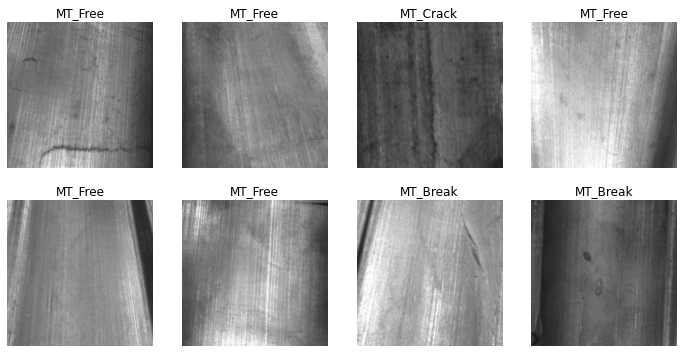

In [9]:
dls = dblock.dataloaders(IMAGES_PATH, bs=8)
dls.show_batch()
batch = dls.one_batch()
print(batch[0].shape, batch[1].shape)
print(batch[0].min(), batch[0].max())
print(batch[1].min(), batch[1].max())

In [10]:
dls.c

6

In [11]:
len(dls.train_ds), len(dls.valid_ds), len(dls.train_ds) + len(dls.valid_ds)

(1076, 268, 1344)

In [12]:
precision = Precision(average='macro')
recall = Recall(average='macro')
metrics = [accuracy, precision, recall]

In [13]:
pickle_fpath = TRAIN_PATH/'export_learn_obj.pkl'
learn = cnn_learner(dls, resnet50, metrics=metrics)
if (pickle_fpath).exists():
    learn = load_learner(pickle_fpath)
    learn.dls = dls
else:
    learn.fine_tune(5)
    learn.export(fname=pickle_fpath)

/home/ubuntu/.local/share/virtualenvs/cv_fastai-CUToeN1p/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


/home/ubuntu/.local/share/virtualenvs/cv_fastai-CUToeN1p/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


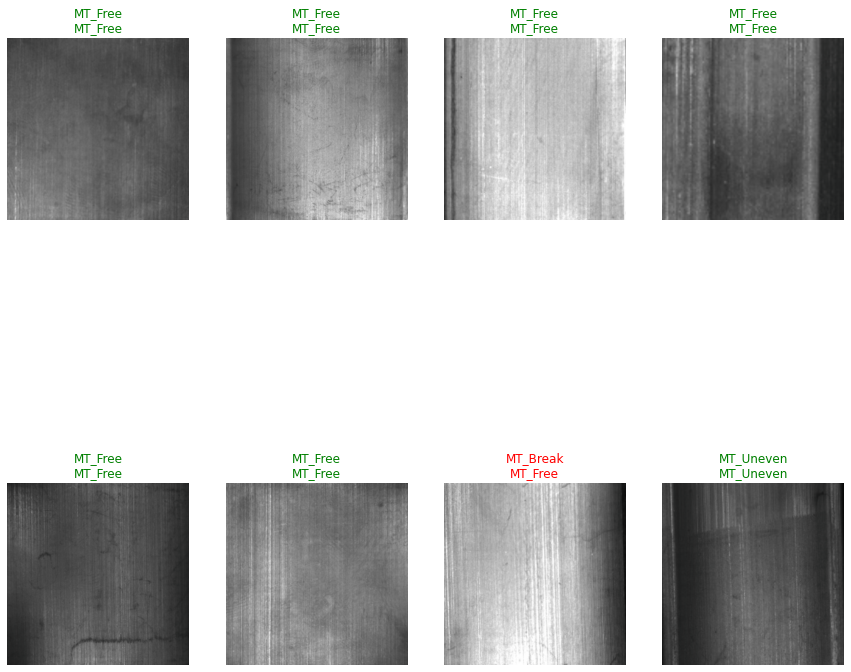

In [23]:
learn.show_results(figsize=(15,15))

In [15]:
loss_val, acc_val, precision_val, recall_val = learn.validate()
loss_val, acc_val, precision_val, recall_val

(0.3412371277809143, 0.89552241563797, 0.9013858848033326, 0.6655897109150217)

In [16]:
# interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_top_losses(12)